<a href="https://colab.research.google.com/github/D4us-M4chanicus/Algorithms-for-classification-problems/blob/main/Study_of_different_machine_learning_algorithms_for_classification_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Обнаружение фальшивых новостей с помощью PassiveAggressiveClassifier**

### **1.1. Загрузка и обработка данных**

In [1]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

In [2]:
# Загружаем датасет и преобразум в датафрэйм "fake_news"
url = "https://storage.yandexcloud.net/academy.ai/practica/fake_news.csv"
fake_news = pd.read_csv(url)

# Смотрим первые 5 строк
fake_news.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
# Указываем, что первая колонка индексная
fake_news.set_index(fake_news.columns[0], inplace=True)

# Получаем краткую информацию и проверяем количество дублей
fake_news.info()
fake_news.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 6335 entries, 8476 to 4330
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6335 non-null   object
 1   text    6335 non-null   object
 2   label   6335 non-null   object
dtypes: object(3)
memory usage: 198.0+ KB


np.int64(29)

In [4]:
# Избавляемся от дублей и сбрасываем индексы
fake_news.drop_duplicates(inplace=True)
fake_news.reset_index(drop=True, inplace=True)

# Проверяем информацию
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6306 entries, 0 to 6305
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6306 non-null   object
 1   text    6306 non-null   object
 2   label   6306 non-null   object
dtypes: object(3)
memory usage: 147.9+ KB


In [5]:
# Разделяем датафрэйм на признаки X и метки y
X = fake_news['text']
y = fake_news['label']

# Разбиваем на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42, stratify=y_temp)

#### **1.1.1. Визуализация**

In [6]:
# Функция для подсчета и вывода соотношения меток
def label_ratios(y):
    counts = y.value_counts()
    percentages = counts / len(y) * 100
    return counts, percentages

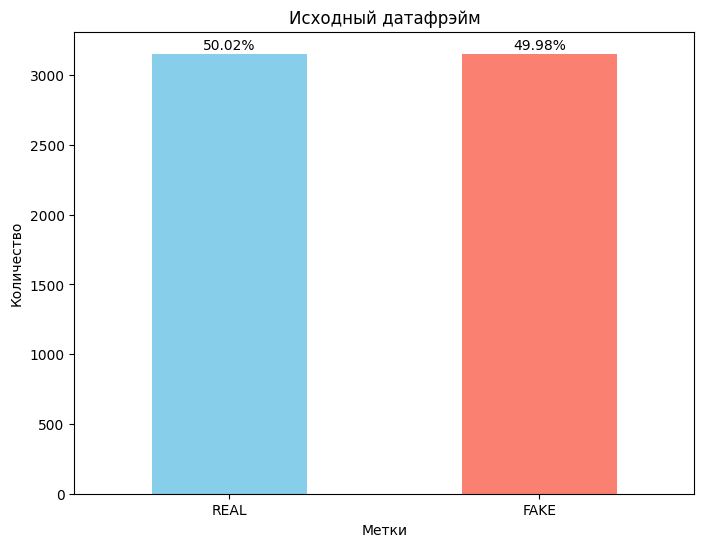

In [7]:
# Игнорировать предупреждения
warnings.filterwarnings("ignore")

# Получаем соотношения меток
counts, percentages = label_ratios(fake_news['label'])

# Создаем график
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Добавляем заголовок и подписи
plt.title('Исходный датафрэйм')
plt.xlabel('Метки')
plt.ylabel('Количество')
plt.xticks(rotation=0)

# Добавляем процент на столбцы
for i in range(len(counts)):
    plt.text(i, counts[i] + 30, f'{percentages[i]:.2f}%', ha='center')

plt.show()

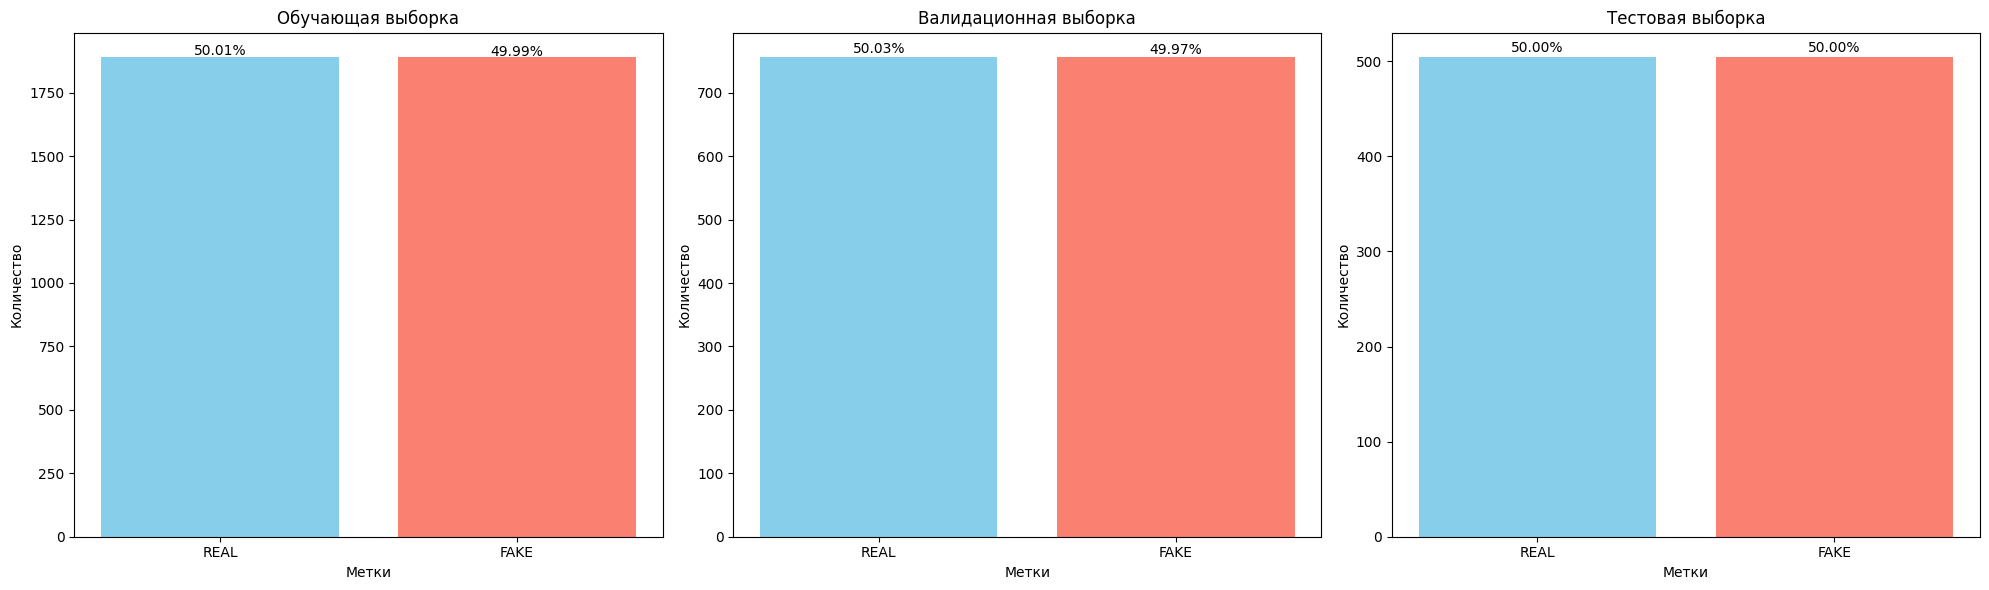

In [8]:
# Получаем соотношения меток
train_counts, train_percentages = label_ratios(y_train)
val_counts, val_percentages = label_ratios(y_val)
test_counts, test_percentages = label_ratios(y_test)

# Создаем фигуру с подграфиками
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Обучающая выборка
axs[0].bar(train_counts.index, train_counts, color=['skyblue', 'salmon'])
axs[0].set_title('Обучающая выборка')
axs[0].set_xlabel('Метки')
axs[0].set_ylabel('Количество')
for i in range(len(train_counts)):
    axs[0].text(i, train_counts[i] + 5, f'{train_percentages[train_counts.index[i]]:.2f}%', ha='center')

# Валидационная выборка
axs[1].bar(val_counts.index, val_counts, color=['skyblue', 'salmon'])
axs[1].set_title('Валидационная выборка')
axs[1].set_xlabel('Метки')
axs[1].set_ylabel('Количество')
for i in range(len(val_counts)):
    axs[1].text(i, val_counts[i] + 5, f'{val_percentages[val_counts.index[i]]:.2f}%', ha='center')

# Тестовая выборка
axs[2].bar(test_counts.index, test_counts, color=['skyblue', 'salmon'])
axs[2].set_title('Тестовая выборка')
axs[2].set_xlabel('Метки')
axs[2].set_ylabel('Количество')
for i in range(len(test_counts)):
    axs[2].text(i, test_counts[i] + 5, f'{test_percentages[test_counts.index[i]]:.2f}%', ha='center')

plt.tight_layout()
plt.show()

### **1.2. Инициализация, обучение и оценка алгоритма**

In [9]:
# Создание модели
pipeline = make_pipeline(TfidfVectorizer(), PassiveAggressiveClassifier())

# Списки для хранения точности на каждой итерации
train_acc = []
val_acc = []

# Обучение модели
for i in range(10):
    pipeline.fit(X_train, y_train)
    train_pred = pipeline.predict(X_train)
    val_pred = pipeline.predict(X_val)

    train_accuracy = accuracy_score(y_train, train_pred)
    val_accuracy = accuracy_score(y_val, val_pred)

    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

# Оценка модели
test_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)

# Вывод результата
print(f'Точность на валидационной выборке: {val_accuracy * 100:.2f}%.')
print(f'Точность на тестовой выборке: {test_accuracy * 100:.2f}%.')

Точность на валидационной выборке: 92.80%.
Точность на тестовой выборке: 92.97%.


#### **1.2.1. Визуализация**

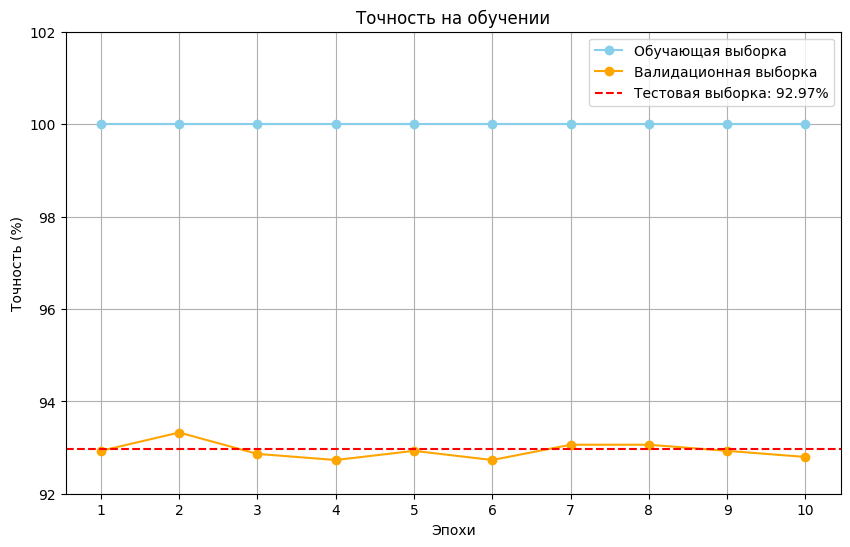

In [10]:
# Визуализация точности
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), [acc * 100 for acc in train_acc], marker='o', label='Обучающая выборка', color='skyblue')
plt.plot(range(1, 11), [acc * 100 for acc in val_acc], marker='o', label='Валидационная выборка', color='orange')
plt.axhline(y=test_accuracy * 100, color='red', linestyle='--', label=f'Тестовая выборка: {test_accuracy * 100:.2f}%')

plt.title('Точность на обучении')
plt.xlabel('Эпохи')
plt.ylabel('Точность (%)')
plt.xticks(range(1, 11))
plt.ylim(92, 102)
plt.legend()
plt.grid()
plt.show()

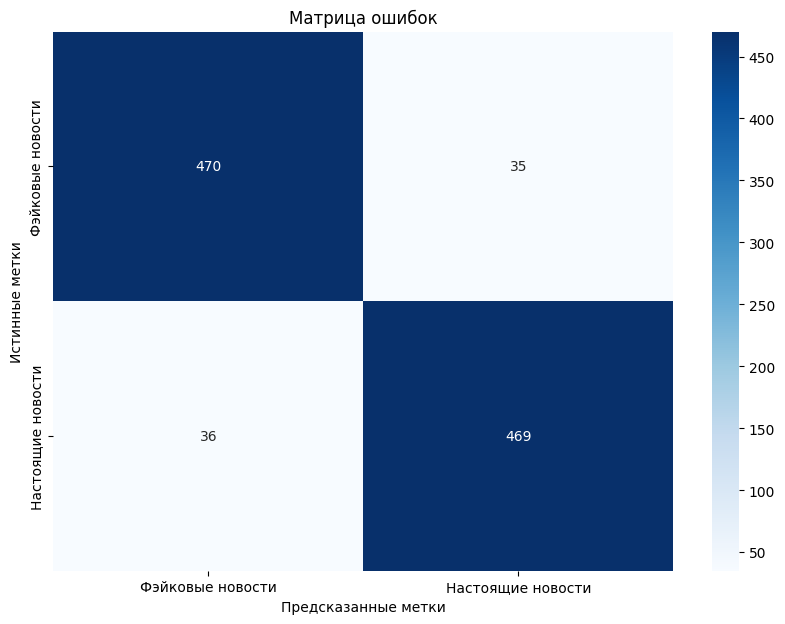

In [ ]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Фэйковые новости', 'Настоящие новости'], yticklabels=['Фэйковые новости', 'Настоящие новости'])
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок')
plt.show()

## **2. Обнаружение болезни паркинсона с помощью XGBoost**

### **2.1. Загрузка и обработка данных**

In [11]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [12]:
# Загрузка данных
url = "https://storage.yandexcloud.net/academy.ai/practica/parkinsons.data"
parkinsons1 = pd.read_csv(url)

# Вывод первых 5 строк
parkinsons1.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [13]:
# Функция для извлечения чисел из имени
def extract_numeric_info(record):
    match = re.match(r'phon_R(\d+)_S(\d+)_(\d+)', record)
    if match:
        round_number = int(match.group(1))  # Извлекаем номер раунда
        session_number = int(match.group(2))  # Извлекаем номер сессии
        entry_number = int(match.group(3))  # Извлекаем индекс записи
        return pd.Series([round_number, session_number, entry_number])
    return pd.Series([None, None, None])  # На случай отсутствия совпадений

In [14]:
# Создаём копию
parkinsons2 = parkinsons1.copy()
# Применяем функцию к столбцу 'name' (увеличиваем размерность)
parkinsons2[['round_number', 'session_number', 'entry_number']] = parkinsons2['name'].apply(extract_numeric_info)

# Получение информации и проверка на дубли
parkinsons2.info()
parkinsons2.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

np.int64(0)

In [15]:
# Извлечение признаков и меток
X = parkinsons2.drop(['status', 'name'], axis=1)
y = parkinsons2['status']

In [16]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### **2.1.1. Визуализация**

In [17]:
# Функция для подсчета количества записей больных и здоровых
def label_ratios(y):
    counts = y.value_counts()
    return counts

In [18]:
counts = label_ratios(y)
sick = counts[1]
healthy = counts[0]
print(f"В изначальном наборе содержится {sick} записей больных и {healthy} здоровых.")

В изначальном наборе содержится 147 записей больных и 48 здоровых.


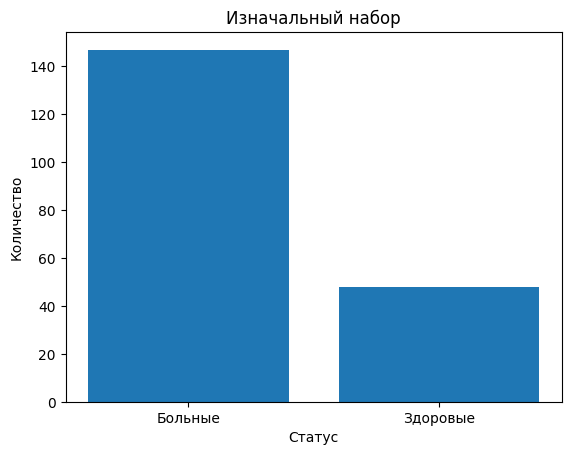

In [19]:
# Создание графика
labels = ['Больные', 'Здоровые']
values = [sick, healthy]

plt.bar(labels, values)
plt.xlabel('Статус')
plt.ylabel('Количество')
plt.title('Изначальный набор')
plt.show()

In [20]:
train_counts = label_ratios(y_train)
train_sick = train_counts[1]  # количество больных
train_healthy = train_counts[0]  # количество здоровых
print(f"В обучающем наборе содержится {train_sick} записей больных и {train_healthy} здоровых.")

В обучающем наборе содержится 118 записей больных и 38 здоровых.


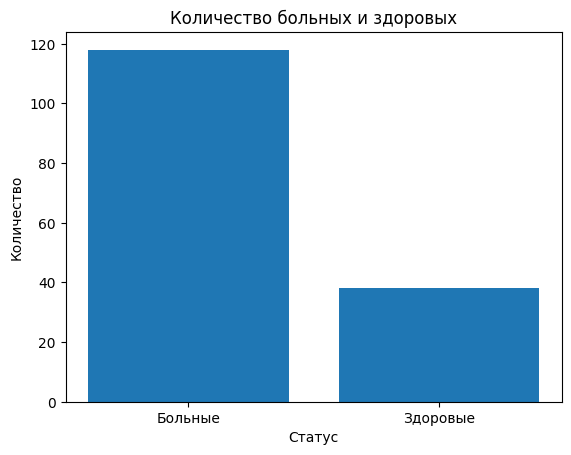

In [21]:
# Создание графика
labels = ['Больные', 'Здоровые']
values = [train_sick, train_healthy]

plt.bar(labels, values)
plt.xlabel('Статус')
plt.ylabel('Количество')
plt.title('Количество больных и здоровых')
plt.show()

In [22]:
test_counts = label_ratios(y_test)
test_sick = test_counts[1]
test_healthy = test_counts[0]
print(f"В тестовом наборе содержится {test_sick} записей больных и {test_healthy} здоровых.")

В тестовом наборе содержится 29 записей больных и 10 здоровых.


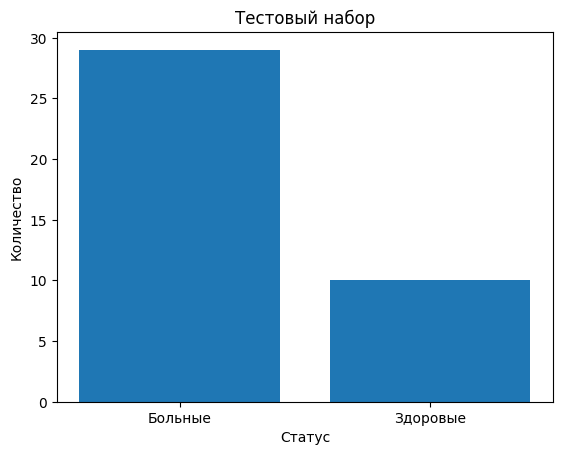

In [23]:
# Создание графика
labels = ['Больные', 'Здоровые']
values = [test_sick, test_healthy]

plt.bar(labels, values)
plt.xlabel('Статус')
plt.ylabel('Количество')
plt.title('Тестовый набор')
plt.show()

### **2.2. Инициализация, обучение и оценка алгоритма**

In [24]:
# Создание модели
pipeline = make_pipeline(StandardScaler(), XGBClassifier(n_estimators=10, eval_metric='logloss'))

# Обучение модели
pipeline.fit(X_train, y_train)

test_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, test_pred)

print(f'Точность на тестовой выборке: {test_accuracy * 100:.2f}%.')

Точность на тестовой выборке: 100.00%.


#### **2.2.1. Визуализация**

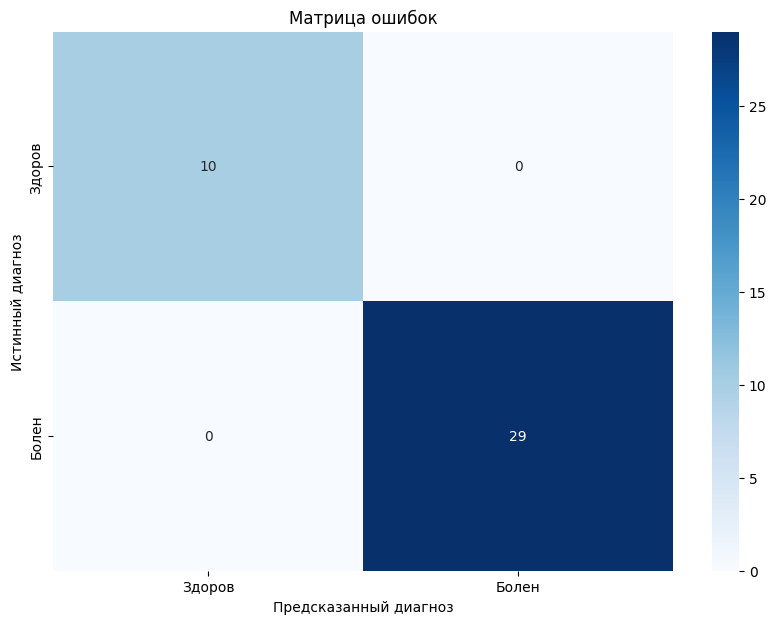

In [25]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Здоров', 'Болен'], yticklabels=['Здоров', 'Болен'])
plt.xlabel('Предсказанный диагноз')
plt.ylabel('Истинный диагноз')
plt.title('Матрица ошибок')
plt.show()

## **3. Анализ использования мобильных устройств и прогнозирование поведения пользователей (RandomForestClassifier, GradientBoostingClassifier, MLPClassifier, SVC)**

### **3.1. Описание**

Целью данного проекта является анализ данных об использовании мобильных устройств, а также выявление наиболее подходящего для прогнозирования класса поведения пользователей на основе различных характеристик алгоритма. Данные включают информацию о времени использования приложений, времени работы экрана, разрядке батареи, количестве установленных приложений, использовании данных и т.д. Эти данные могут помочь в понимании паттернов поведения пользователей и в дальнейшем улучшении пользовательского опыта.

Используемые данные включают следующие столбцы:

- **User ID** - уникальный идентификатор для каждого пользователя.
- **Device Model** - модель смартфона пользователя.
- **Operating System** - операционная система устройства (iOS или Android).
- **App Usage Time (min/day)** - ежедневное время, затрачиваемое на мобильные приложения, измеряемое в минутах.
- **Screen On Time (hours/day)** - среднее количество часов в день, когда экран активен.
- **Battery Drain (mAh/day)** - ежедневный расход батареи в мАч.
- **Number of Apps Installed** - общее количество приложений, доступных на устройстве.
- **Data Usage (MB/day)** - ежедневное потребление мобильных данных в мегабайтах.
- **Age** - возраст пользователя.
- **Gender** - пол пользователя (мужчина или женщина).
- **User Behavior Class** - классификация поведения пользователя на основе моделей использования (от 1 до 5).

Мы будем визуализировать данные и построим модель для прогнозирования класса поведения пользователей.

Этапы работы:

- Загрузка и анализ данных
- Визуализация данных
- Моделирование
- Оценка модели

### **3.2. Загрузка и обработка данных**

#### **3.2.1. Загрузка данных**

In [26]:
# Импорт необходимых библиотек
from requests import get
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [27]:
# Получение датасета
response = get("https://www.kaggle.com/api/v1/datasets/download/valakhorasani/mobile-device-usage-and-user-behavior-dataset")

In [28]:
# Запись содержимого в файл
with open('mobile-device-usage-and-user-behavior-dataset.zip', 'wb') as f:
    f.write(response.content)

In [29]:
# Разархивация датасета в директорию 'mobile-device-usage-and-user-behavior-dataset'
!unzip -qo "mobile-device-usage-and-user-behavior-dataset.zip" -d ./mobile-device-usage-and-user-behavior-dataset

# Папка с распакованным датасетом
FILE_PATH = './mobile-device-usage-and-user-behavior-dataset'

In [30]:
# Получение содержимого
os.listdir(FILE_PATH)

['user_behavior_dataset.csv']

In [31]:
# Создание датафрэйма
user_behavior = pd.read_csv(f'{FILE_PATH}/user_behavior_dataset.csv')

#### **3.2.2. Анализ**

In [32]:
# Вывод первых 5 строк
user_behavior.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [33]:
# Создание копии
user_behavior1 = user_behavior.copy()

# Преобразование 'Operating System' и 'Gender' в числовой формат
user_behavior1['Operating System'] = user_behavior1['Operating System'].map({'Android': 0, 'iOS': 1})
user_behavior1['Gender'] = user_behavior1['Gender'].map({'Male': 0, 'Female': 1})

# Вывод первых 5 строк копии
user_behavior1.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,0,393,6.4,1872,67,1122,40,0,4
1,2,OnePlus 9,0,268,4.7,1331,42,944,47,1,3
2,3,Xiaomi Mi 11,0,154,4.0,761,32,322,42,0,2
3,4,Google Pixel 5,0,239,4.8,1676,56,871,20,0,3
4,5,iPhone 12,1,187,4.3,1367,58,988,31,1,3


In [34]:
# Получение краткой информации и проверка на дубли
user_behavior1.info()
user_behavior1.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User ID                     700 non-null    int64  
 1   Device Model                700 non-null    object 
 2   Operating System            700 non-null    int64  
 3   App Usage Time (min/day)    700 non-null    int64  
 4   Screen On Time (hours/day)  700 non-null    float64
 5   Battery Drain (mAh/day)     700 non-null    int64  
 6   Number of Apps Installed    700 non-null    int64  
 7   Data Usage (MB/day)         700 non-null    int64  
 8   Age                         700 non-null    int64  
 9   Gender                      700 non-null    int64  
 10  User Behavior Class         700 non-null    int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 60.3+ KB


np.int64(0)

In [35]:
# Статистическое описание
statistical = user_behavior1.describe()
statistical

,User ID,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
count,700.00000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,350.50000,0.208571,271.128571,5.272714,1525.158571,50.681429,929.742857,38.482857,0.480000,2.990000
std,202.21688,0.406578,177.199484,3.068584,819.136414,26.943324,640.451729,12.012916,0.499957,1.401476
min,1.00000,0.000000,30.000000,1.000000,302.000000,10.000000,102.000000,18.000000,0.000000,1.000000
25%,175.75000,0.000000,113.250000,2.500000,722.250000,26.000000,373.000000,28.000000,0.000000,2.000000
50%,350.50000,0.000000,227.500000,4.900000,1502.500000,49.000000,823.500000,38.000000,0.000000,3.000000
75%,525.25000,0.000000,434.250000,7.400000,2229.500000,74.000000,1341.000000,49.000000,1.000000,4.000000
max,700.00000,1.000000,598.000000,12.000000,2993.000000,99.000000,2497.000000,59.000000,1.000000,5.000000


##### **3.2.2.1. Визуализация**

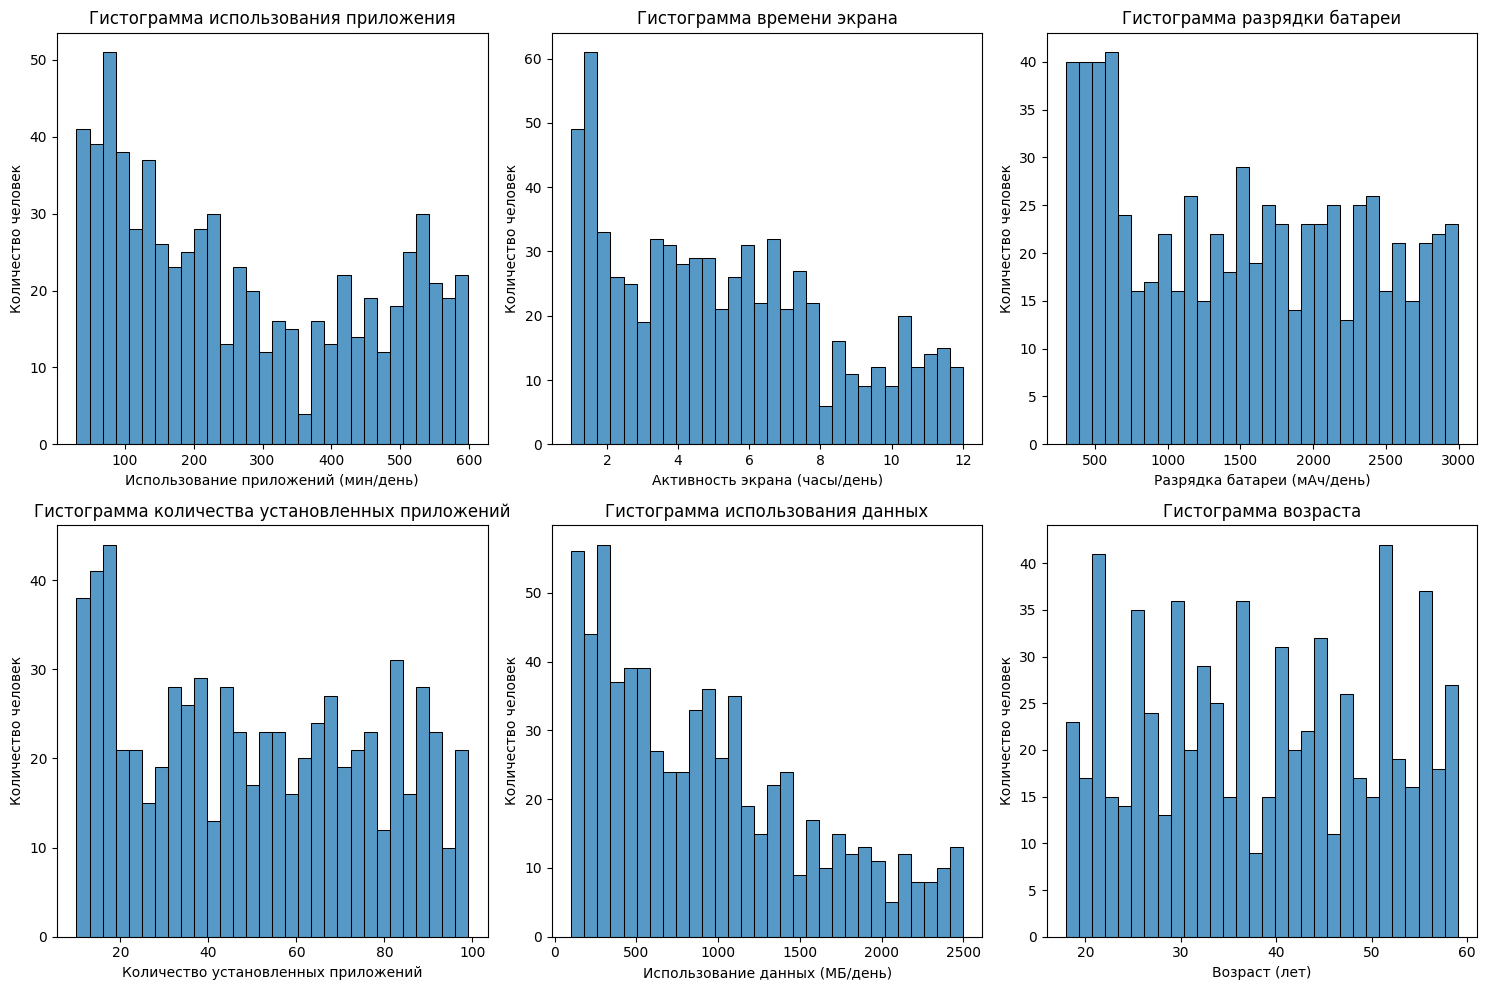

In [36]:
# Создание гистограмм
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.histplot(user_behavior1["App Usage Time (min/day)"], bins=30)
plt.title('Гистограмма использования приложения')
plt.xlabel('Использование приложений (мин/день)')
plt.ylabel('Количество человек')

plt.subplot(2, 3, 2)
sns.histplot(user_behavior1["Screen On Time (hours/day)"], bins=30)
plt.title('Гистограмма времени экрана')
plt.xlabel('Активность экрана (часы/день)')
plt.ylabel('Количество человек')

plt.subplot(2, 3, 3)
sns.histplot(user_behavior1["Battery Drain (mAh/day)"], bins=30)
plt.title('Гистограмма разрядки батареи')
plt.xlabel('Разрядка батареи (мАч/день)')
plt.ylabel('Количество человек')

plt.subplot(2, 3, 4)
sns.histplot(user_behavior1["Number of Apps Installed"], bins=30)
plt.title('Гистограмма количества установленных приложений')
plt.xlabel('Количество установленных приложений')
plt.ylabel('Количество человек')

plt.subplot(2, 3, 5)
sns.histplot(user_behavior1["Data Usage (MB/day)"], bins=30)
plt.title('Гистограмма использования данных')
plt.xlabel('Использование данных (МБ/день)')
plt.ylabel('Количество человек')

plt.subplot(2, 3, 6)
sns.histplot(user_behavior1["Age"], bins=30)
plt.title('Гистограмма возраста')
plt.xlabel('Возраст (лет)')
plt.ylabel('Количество человек')

plt.tight_layout()
plt.show()

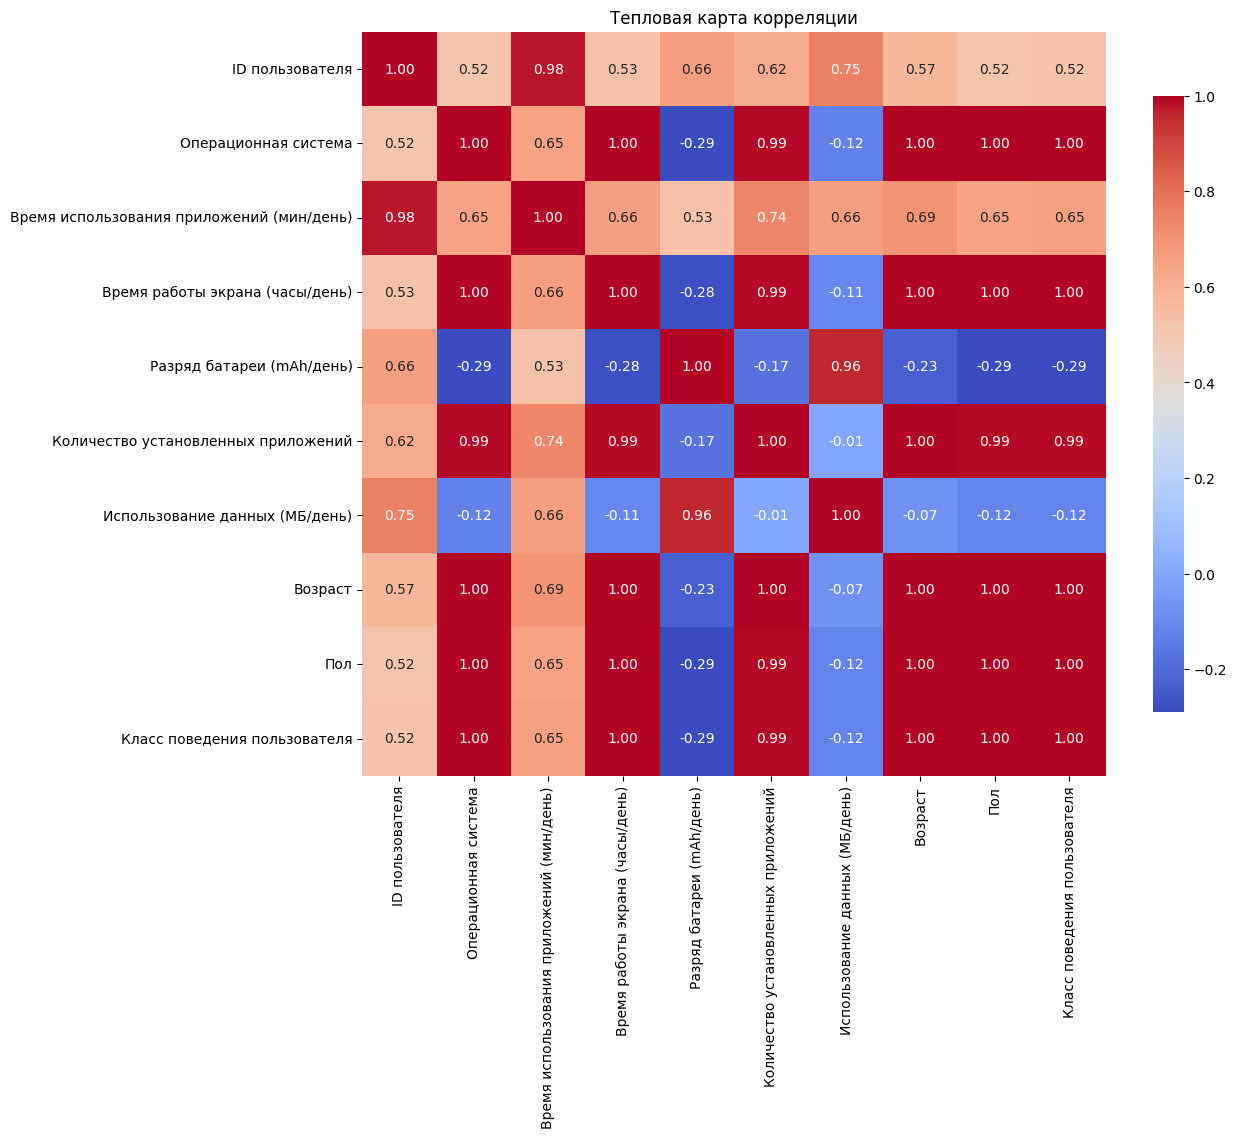

In [37]:
# Вычисление корреляции
correlation_matrix = statistical.corr()

# Создание тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8},
            xticklabels=['ID пользователя', 'Операционная система', 'Время использования приложений (мин/день)',
                         'Время работы экрана (часы/день)', 'Разряд батареи (mAh/день)',
                         'Количество установленных приложений', 'Использование данных (МБ/день)',
                         'Возраст', 'Пол', 'Класс поведения пользователя'],
            yticklabels=['ID пользователя', 'Операционная система', 'Время использования приложений (мин/день)',
                         'Время работы экрана (часы/день)', 'Разряд батареи (mAh/день)',
                         'Количество установленных приложений', 'Использование данных (МБ/день)',
                         'Возраст', 'Пол', 'Класс поведения пользователя'])
plt.title('Тепловая карта корреляции')
plt.show()

##### **3.2.2.2. Выводы**

**Анализ структуры данных показал, что дубли и пропуски отсутствуют.**

1. Идентификатор пользователя имеет сильное влияние на поведение пользователя в целом.
2. Операционная система имеет тесную связь с количеством установленных приложений и возрастом пользователей.
3. Время работы экрана и использование данных плотно связаны и одно влияет на другое.
4. Количество установленных приложений напрямую связано с временем использования приложений и использованием данных.
5. Возраст и пол пользователей оказывают некоторое влияние на выбор операционной системы и время использования приложений.
6. Поведенческие классы пользователей тесно связаны с временем использования приложений, количеством установленных приложений и использованием данных.

#### **3.2.3. Обработка данных**

In [38]:
# Разделение на признаки X и метки y
X = user_behavior1.drop(columns=['User ID', 'User Behavior Class'])
X = pd.get_dummies(X, drop_first=True)  # Преобразуем категориальные переменные в числовые
y = user_behavior1['User Behavior Class']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [39]:
X

,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,Device Model_OnePlus 9,Device Model_Samsung Galaxy S21,Device Model_Xiaomi Mi 11,Device Model_iPhone 12
0,0,393,6.4,1872,67,1122,40,0,False,False,False,False
1,0,268,4.7,1331,42,944,47,1,True,False,False,False
2,0,154,4.0,761,32,322,42,0,False,False,True,False
3,0,239,4.8,1676,56,871,20,0,False,False,False,False
4,1,187,4.3,1367,58,988,31,1,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
695,1,92,3.9,1082,26,381,22,0,False,False,False,True
696,0,316,6.8,1965,68,1201,59,0,False,False,True,False
697,0,99,3.1,942,22,457,50,1,False,False,False,False
698,0,62,1.7,431,13,224,44,0,False,True,False,False


##### **3.2.3.1. Визуализация**

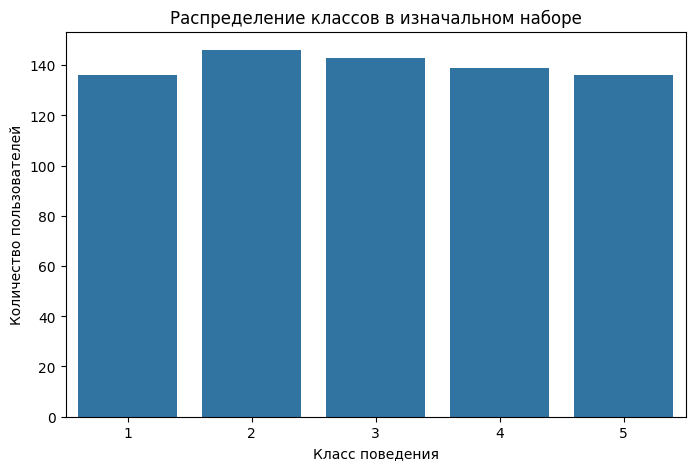

In [40]:
# Визуализация распределения классов поведения пользователей
plt.figure(figsize=(8, 5))
sns.countplot(data=user_behavior1, x='User Behavior Class')
plt.title('Распределение классов в изначальном наборе')
plt.xlabel('Класс поведения')
plt.ylabel('Количество пользователей')
plt.show()

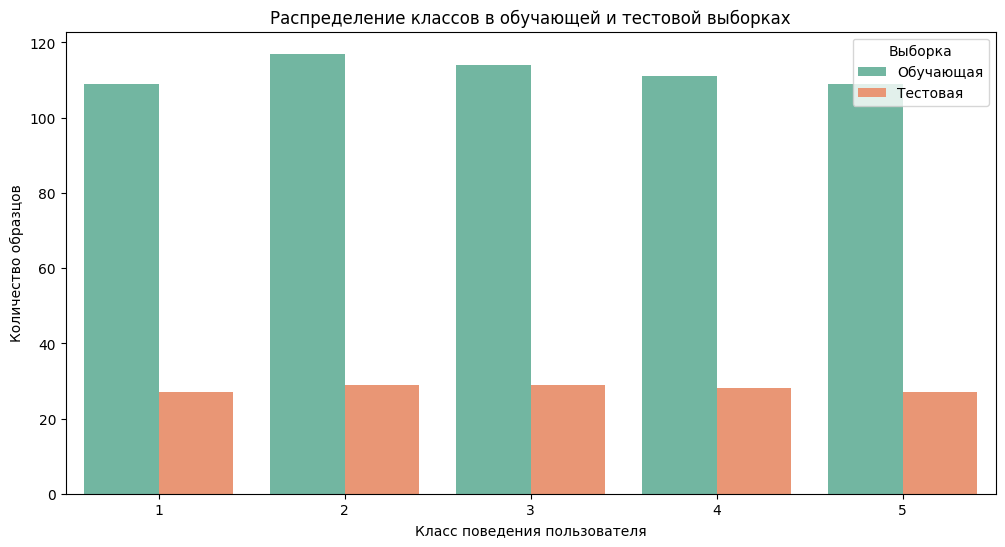

In [41]:
# Объединяем метки с обучающей и тестовой выборками
train_data = pd.DataFrame(y_train, columns=['User Behavior Class'])
train_data['Set'] = 'Обучающая'

test_data = pd.DataFrame(y_test, columns=['User Behavior Class'])
test_data['Set'] = 'Тестовая'

# Объединяем данные для визуализации
combined_data = pd.concat([train_data, test_data])

# Визуализация распределения классов
plt.figure(figsize=(12, 6))
sns.countplot(x='User Behavior Class', hue='Set', data=combined_data, palette='Set2')
plt.title('Распределение классов в обучающей и тестовой выборках')
plt.xlabel('Класс поведения пользователя')
plt.ylabel('Количество образцов')
plt.legend(title='Выборка')
plt.show()

### **3.3. Инициализация, обучение и оценка алгоритмов**

In [ ]:
# Инициализация алгоритмов
GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
SVC = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42)
RFC = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
MLPC = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, random_state=42)

In [ ]:
models = [GBC, SVC, RFC, MLPC]
model_names = ['Gradient Boosting', 'Support Vector Classifier', 'Random Forest', 'MLP Classifier']

# Словарь для хранения результатов
results = {}

# Обучение и расчёт метрик
for model, name in zip(models, model_names):
    model.fit(X_train, y_train)

    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Расчет метрик
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Кросс-валидация
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cv_scores.mean()

    # Сохранение результатов
    results[name] = {
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'CV Mean Accuracy': cv_mean,
        'Classification Report': classification_report(y_test, y_test_pred)
    }

# Вывод резюме
for name, metrics in results.items():
    print(f"=== {name} ===")
    print(f"Точность на обучающей выборке: {metrics['Train Accuracy'] * 100:.2f}%.")
    print(f"Точность на тестовой выборке: {metrics['Test Accuracy'] * 100:.2f}%.")
    print(f"Средняя точность на кросс-валидации: {metrics['CV Mean Accuracy'] * 100:.2f}%.")
    print("Классификационный отчет:")
    print(metrics['Classification Report'])

=== Gradient Boosting ===
Точность на обучающей выборке: 100.00%.
Точность на тестовой выборке: 100.00%.
Средняя точность на кросс-валидации: 100.00%.
Классификационный отчет:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        27

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140

=== Support Vector Classifier ===
Точность на обучающей выборке: 99.82%.
Точность на тестовой выборке: 100.00%.
Средняя точность на кросс-валидации: 99.82%.
Классификационный отчет:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00 

#### **3.3.1. Визуализация**

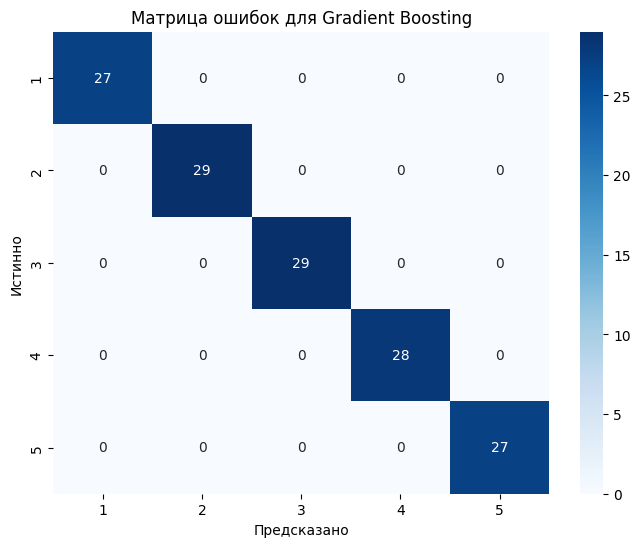

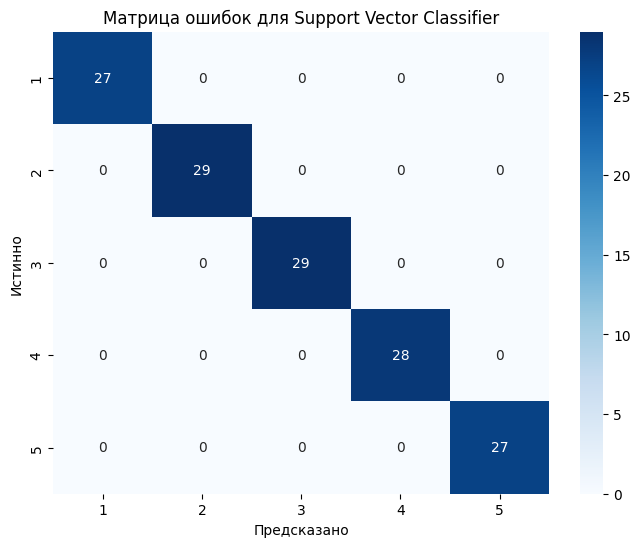

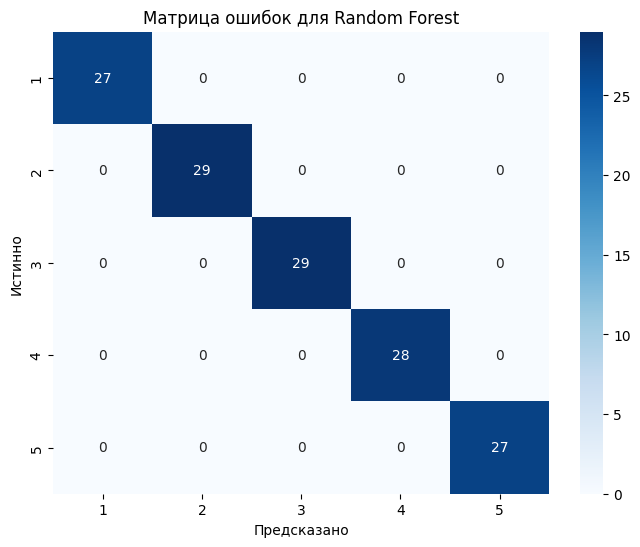

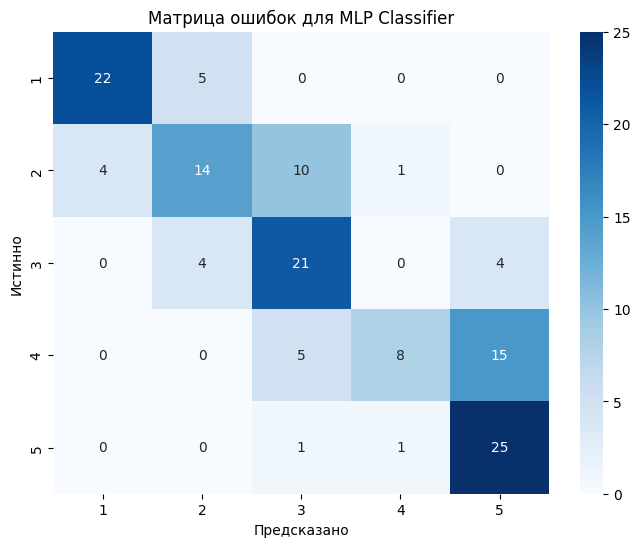

In [ ]:
# Визуализация матрицы ошибок для каждой модели
for model, name in zip(models, model_names):
    # Получаем предсказания для тестового набора
    y_test_pred = model.predict(X_test)

    # Создаем матрицу ошибок
    cm = confusion_matrix(y_test, y_test_pred)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Матрица ошибок для {name}')
    plt.xlabel('Предсказано')
    plt.ylabel('Истинно')
    plt.show()

### **3.4. Выводы**

В этом проекте мы проанализировали данные о поведении пользователей мобильных устройств, визуализировали их и построили модели для прогнозирования класса поведения.

Модели **Gradient Boosting**, **SVC** и **Random Forest** демонстрируют отличные результаты.

Модель **MLP Classifier** показывает недостаточную производительность.

Рекомендуется использовать модели (**Gradient Boosting, SVC** или **Random Forest**) для задач, где требуется высокая точность,